In [1]:
%load_ext autoreload
%autoreload 2

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import os, glob, json
import config as cfg
from IPython.display import display
from ipywidgets import widgets, Layout
from module.cluster import VAE_Cluster
from module.vmt import VMT, TemplateD
from module.vae import GaussianKLLoss
from dataset import KKDayUser, seq_collate
from constant import Constants
from utils import get_fixed_temperature, get_losses
from sklearn.cluster import KMeans
import numpy as np
from tensorboardX import SummaryWriter
from utils import gradient_penalty, str2bool, chunks
from sklearn.manifold import SpectralEmbedding
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from shutil import copyfile
import pickle
import seaborn as sns
from collections import namedtuple

In [121]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [122]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [123]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [124]:
log_name = 'save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59'
iteration = 80000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)

### Lets Visualize template first

In [125]:
log_name = 'save/gan_tempest_w-latent-biset-2020-07-15-21-09-32/'
checkpoint = 'checkpoint_30000.pt'

from module.vmt import VMT
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
id_mapping = torch.load(os.path.join(args.cache_path, 'id_mapping.pt'))
user_size = len(id_mapping['user2id'])
user_size = user_size
prod_size = len(id_mapping['prod2id'])


model = VMT(args.gen_embed_dim, args.vocab_size,
            enc_hidden_size=256, dec_hidden_size=256, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset, user_embedding=True, user_size=user_size,
            max_seq_len=args.max_seq_len-1, gpu=True).cuda()
model.load_state_dict(torch.load(os.path.join(log_name,checkpoint))['model'])

id2user = { value: key for key, value in id_mapping['user2id'].items() }


In [126]:
id2user = { value: key for key, value in id_mapping['user2id'].items() }

In [127]:
from dataset import TemPest, tempest_collate
valid_dataset = TemPest(args.cache_path, 'valid')
print(len(valid_dataset))
eval_dataloader = torch.utils.data.DataLoader(valid_dataset, num_workers=8,
                        collate_fn=tempest_collate, batch_size=20, shuffle=False, drop_last=True)

dataset/valid.pt
1761


Generate examples

In [128]:
sentences, references = [], []
temp_latent = []; temp_outputs= []
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        empty_users = users == -1
        batch_size = len(empty_users)
        users_filled = users.detach()
        users_filled[empty_users] = torch.randint(0, user_size, ( int(empty_users.sum()),  ))

        if cfg.CUDA:
            src_inputs = src_inputs.cuda()
            target = target.cuda()
            tmp = tmp.cuda()
            inputs = inputs.cuda()
            users_filled = users_filled.cuda()

        desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        for latent_ in tmp_latent:
            temp_latent.append(latent_.cpu().numpy().flatten())
        for latent_ in tmp_outputs:
            temp_outputs.append(latent_.cpu().numpy())
        user_embeddings = model.user_embedding( users_filled )
        _, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
                desc_outputs, tmp_outputs,
                max_length=target.shape[1])

        for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
            reference = []
            for token in sent_token:
                if token.item() == Constants.EOS:
                    break
                reference.append(valid_dataset.tokenizer.idx2word[token.item()] )
            references.append(''.join(reference))

            sent = output_title[idx]
            sentence = []
            for token in sent:
                if token.item() == Constants.EOS:
                    break
                sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
            sentences.append(''.join(sentence))

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [129]:
X, title = [], []
print(len(temp_latent))
for idx, latent in enumerate(temp_latent):
    X.append(latent)
    title.append(references[idx])
temp_outputs = np.array(temp_outputs)
title = np.array(title)
X = np.array(X)

1760


### Visualize categorical distribution of the first template latent

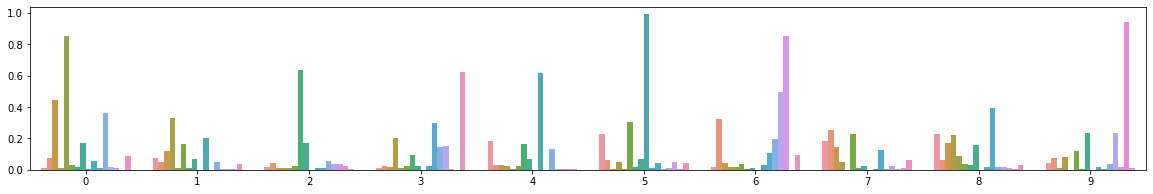

In [130]:
plt.rcParams["figure.figsize"] = (20,3)

data = {'y': [], 'bins': [], 'type': []}
for idx, latent in enumerate(X[0].reshape(args.tmp_latent_dim, args.tmp_cat_dim)):
    data['y'] += list(range(len(latent)))
    data['bins'] += list(latent)
    data['type'] += list([idx]*len(latent))
g = sns.barplot(x='y', y='bins', data=data, hue='type')
g.legend_.remove()

## Sample some latent as reference

In [131]:
with torch.no_grad():
    for idx, batch in enumerate(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        non_empty_users = users != -1
        if cfg.CUDA:
            src_inputs = src_inputs[non_empty_users].cuda()
            target = target[non_empty_users].cuda()
            tmp = tmp[non_empty_users].cuda()
            inputs = inputs[non_empty_users].cuda()
            users = users[non_empty_users].cuda()

        if non_empty_users.sum() > 0 and idx > 20:
            print('found')
            break

found


## Sample other latent as target

In [132]:
cnt = 0
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        cnt += 1
        users2 = batch['users']
        non_empty_users = users2 != -1
        if cfg.CUDA:
            users2 = users2[non_empty_users].cuda()
        if non_empty_users.sum() > 0 and cnt > 10:
            print('found')
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


found


Generate reference title from reference latent

In [97]:
desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
tmp_outputs, tmp_latent = model.encode_tmp(tmp)
user_embeddings = model.user_embedding( users )
_, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
original_sentences = []
original_pairs = []
for idx, sent in enumerate(output_title.cpu()):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_pairs.append("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_sentences.append(''.join(sentence[:50]).strip())

user: c0ae0ecd-6971-417f-8796-85479f45ffc0 | 【中央義大利遊】N桌山霍格華茲Pass熊、
user: 66c585c8-c108-48f5-9ee9-dd95bc395128 | 【暢遊奧蘭多必備】】】城市通行證--電子門票（免費）
user: 8d2dd7e7-c8cd-4667-bd8b-1c3dc7b8bbbe | 【卡丁車空中體驗】成為南方體驗直升機體驗
user: a76d91aa-33f9-4a02-9bb4-0a6c94a1e18f | 【JRPASS】關西廣域鐵路周遊券
user: d2715baa-558c-4acd-bc45-ceabc5fbd760 | 【洛杉磯自由行必備】洛杉磯好萊塢AngelesCard洛杉磯景點一卡通
user: 7ee6dea3-1d4e-4389-bd2c-38f52705900b | 【日本比必備】】大邱路線巴士車票（


In [119]:
user2_embeddings = model.user_embedding( users2[:6,] )
_, output_title = model.decode(
        tmp_latent,
        #control_latent[:6].cuda(), 
        desc_latent, user2_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
for idx, (sent, origin_pair) in enumerate(zip(output_title, original_pairs)):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : "+origin_pair)
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

Can we randomly sample template latent for use? ( Only applicable for model without BiSET )

In [99]:
latent_dim = args.tmp_latent_dim
categorical_dim = args.tmp_cat_dim
M =  args.tmp_cat_dim * args.tmp_latent_dim
np_y = np.zeros((M, categorical_dim), dtype=np.float32)
np_y[range(M), np.random.choice(categorical_dim, M)] = 1
np_y = np.reshape(np_y, [ M // latent_dim, latent_dim, categorical_dim])[:6, :,:]

In [104]:
random_sample = torch.from_numpy(np_y).view(6, latent_dim * categorical_dim).cuda()
_, output_title = model.decode(
        random_sample,
        #control_latent[:6].cuda(), 
        desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : ",original_pairs[idx])
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

old :  user: c0ae0ecd-6971-417f-8796-85479f45ffc0 | 【中央義大利遊】N桌山霍格華茲Pass熊、
new : user: 5514bbb6-5075-471b-9c11-b2a7a619f5af | 【中央奇幻遊】N桌山Park（熊）

old :  user: 66c585c8-c108-48f5-9ee9-dd95bc395128 | 【暢遊奧蘭多必備】】】城市通行證--電子門票（免費）
new : user: 86835d7b-5183-4873-afa9-29da28075bcc | 【暢遊美國必備】】經典觀光通行證--電子門票（

old :  user: 8d2dd7e7-c8cd-4667-bd8b-1c3dc7b8bbbe | 【卡丁車空中體驗】成為南方體驗直升機體驗
new : user: 58019536-1ee4-44ea-add9-804f63d01afd | 【卡丁車紓壓體驗】成為南方體驗

old :  user: a76d91aa-33f9-4a02-9bb4-0a6c94a1e18f | 【JRPASS】關西廣域鐵路周遊券
new : user: 079d82bf-12a3-464d-be52-c0ed33ea06a3 | 【JRPASS】關西廣域鐵路周遊券

old :  user: d2715baa-558c-4acd-bc45-ceabc5fbd760 | 【洛杉磯自由行必備】洛杉磯好萊塢AngelesCard洛杉磯景點一卡通
new : user: daa12bd2-fb26-4ce2-b12b-788ed6de84fd | 【洛杉磯自由行必備】洛杉磯好萊塢AngelesCard洛杉磯景點一卡通

old :  user: 7ee6dea3-1d4e-4389-bd2c-38f52705900b | 【日本比必備】】大邱路線巴士車票（
new : user: 30ed0e8e-a67e-493a-b52e-951fc50c79a1 | 【日本交通卡】台灣周遊卡/宿霧



Visualize template latent 

In [105]:
pca = PCA(n_components=2)
one_hot_x = [  torch.softmax(torch.from_numpy(row).reshape(10, 16), dim=-1).numpy()[1]  for row in X   ]
X_r = pca.fit_transform(X)
nbrs = SpectralClustering(n_clusters=2).fit(X_r)
y = nbrs.labels_
print(set(y))

{0, 1}


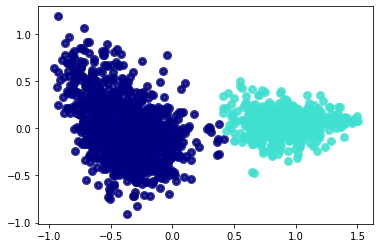

In [112]:
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()
target_names = [0,1]
colors = ['navy', 'turquoise']
lw = 3
for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [115]:
no_bracket_latent = X[y==1][6:12]
no_bracket_latent_out = temp_outputs[y==1][6:12]
templates = title[y==1][6:12]

output_titles = []
for idx, (_latent, _latent_output) in enumerate(zip(no_bracket_latent, temp_outputs)):
    _latent = torch.from_numpy(_latent).view(1, latent_dim * categorical_dim).cuda()
    _latent_output = torch.from_numpy(_latent_output).unsqueeze(0).cuda()
    _, output_title = model.decode(
            _latent,
            desc_latent[[idx]], user2_embeddings[[idx]], 
            desc_outputs[[idx]], _latent_output,
            max_length=target.shape[1])
    output_titles.append(output_title.cpu())

output_titles = torch.cat(output_titles)
for idx, sent in enumerate(output_titles):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print('target template   %s' % templates[idx])
    print('origin gen title %s ' % original_sentences[idx])
    print('new gen title    %s\n' % ''.join(sentence[:50]).strip())
#     print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

target template   卡門浮潛和廢墟探險
origin gen title 【中央義大利遊】N桌山霍格華茲Pass熊、 
new gen title    【中央義大利】】N桌山（（Khum）

target template   阿姆斯特丹：A'DAM瞭望臺和OvertheEdge鞦韆票
origin gen title 【暢遊奧蘭多必備】】】城市通行證--電子門票（免費） 
new gen title    【暢遊美國必備】】城市觀光通行證--5天門票

target template   蒙巴薩出發：查沃國家公園2日狩獵遊
origin gen title 【卡丁車空中體驗】成為南方體驗直升機體驗 
new gen title    【卡丁車高空活動】】】飛機體驗後飛機

target template   小琉球好玩。珊瑚礁島嶼風光
origin gen title 【JRPASS】關西廣域鐵路周遊券 
new gen title    【JRPASS】關西廣域鐵路周遊券

target template   【台東包車半日遊】快速遊台東熱門景點
origin gen title 【洛杉磯自由行必備】洛杉磯好萊塢AngelesCard洛杉磯景點一卡通 
new gen title    【洛杉磯自由行行自由任選任選景點洛杉磯景點景點

target template   米蘭：斯卡拉博物館與劇院旅遊
origin gen title 【日本比必備】】大邱路線巴士車票（ 
new gen title    11272老爺車！本島桃園/大邱單程



In [116]:
print(title[y==0][:60])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '巴耶內瓦多和Cousiño馬庫爾：從聖地亞哥一日遊'
 '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊' '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '《沖繩景點通行票》精選熱門景點＋</UNK>水族館'
 '【北投人氣溫泉】北投麗禧溫泉雙人湯屋＋雙人下午茶' '【艾菲爾鐵塔快速入場】巴黎艾菲爾鐵塔快速入場與塞納河遊船'
 '【普吉唯一友善大象營】親密互動半日體驗' '【中國安徽文化歷史景點】呈</UNK>門票' '【新加坡郊野深度遊】烏敏島紅樹林獨木舟探險'
 '【騎單車遊曼谷】泰好吃！街頭美食饕客團' '【超值沙巴跳島】沙比島和馬穆迪島一日遊' '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）'
 '【曼谷泰式按摩】BhawaSpa按摩體驗（獨家九折預約）' '【Discovery探索基地】'
 '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）' '【真愛宣言，致深愛電影的你】韓國</UNK>電影博物館'
 '【首爾人氣美食餐廳】</UNK>家黑豬肉專賣店' '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)'
 '【法式浪漫極致】艾菲爾鐵塔晚宴、塞納河遊船' '【SPA</UNK>】大邱以利</UNK>入場券（上</UNK>）'
 '【騎單車遊曼谷】早安曼谷單車之旅' '【小團划算】桃園機場臺北市區接機服務（七人座）'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【七島跳島日落遊】喀比必去浪漫之旅'
 '【巴黎夜未眠】夜間觀光巴士城市導覽、紅磨坊歌舞秀' '3天2夜親子遊' '【瘋狂飛瀑群】桃園小烏來。

In [118]:
print(title[y==1][:60])

['優先進入：柏林杜莎夫人蠟像館' '漢堡喜劇之旅' '倫敦和哈利·波特場景私人半日遊' '坎昆極限林冠溜索' '墾丁高雄零阻礙輕鬆包車接駁'
 '組合：在</UNK>和觀光游到伊瓜蘇瀑布' '卡門浮潛和廢墟探險' "阿姆斯特丹：A'DAM瞭望臺和OvertheEdge鞦韆票"
 '蒙巴薩出發：查沃國家公園2日狩獵遊' '小琉球好玩。珊瑚礁島嶼風光' '【台東包車半日遊】快速遊台東熱門景點' '米蘭：斯卡拉博物館與劇院旅遊'
 '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！' '柏林景點和亮點：3.5小時自行車旅遊'
 '日月潭山光水色豐富一日遊' '波爾圖精選徒步遊' '黃石國家公園老忠實噴泉與野生動物一日遊'
 '紐倫堡舊城與全</UNK></UNK>會場徒步行' '攀登雪梨海港大橋' '巴哈吉普車遊覽聖地亞哥洛斯卡沃斯：驅動器或騎'
 '妓院、美食與豪飲:聖地亞哥瓦斯</UNK>徒步遊' '柏林歡迎卡：交通、優惠和旅遊指南書'
 '台北車站精緻旅舍：STARHostel3-4晚超值套餐（免費送台北單車導覽！）' '阿雷納爾湖：半天拉財神山地自行車騎'
 '在墨西哥城的墨西哥民俗芭蕾' '坎昆出發，奇琴伊察延長全日遊' '葡萄牧場：瓦豪河谷酒莊自行車之旅' '聖伊格納西奧與萬達地雷：從伊瓜蘇港旅遊'
 '華盛頓特區亮點Segway代步車旅遊' '豪華</UNK>馬斯美食之旅從麥德林'
 '巴士一日tour〖世界遺產〗今歸仁城＋美麗海水族館多語言語音導覽)' '大沼澤地印第安保護區白天狩獵遊' '芝加哥歡迎之旅：私有遊覽與本地'
 '普羅旺斯地區艾克斯：呂貝隆山區市集及</UNK>間旅遊' '麥德林ATV冒險' '從福塔萊薩：8小時一日遊摩洛布蘭科'
 '卡波聖盧卡斯豪華巡航冒險半日遊' '復古的菲亞特500汽車前往基安蒂村莊進行1日自駕遊' '晚餐遊船、埃菲爾鐵塔以及紅磨坊香檳'
 '濟州Aquaplanet水族館門票' '【水路一次玩盡】維也納全景遊船與城市觀光旅遊' '吉隆坡國際機場入境接駁'
 '埃斯科里亞爾修道院和山谷的教堂5小時導覽遊' '蒂茹卡森林旅遊與瀑布' '魁北克互動式街頭劇場：“新法蘭西的罪行＂'
 '冒險港主題公園和法拉利樂園的門票' '斯德哥爾摩群島全日航海遊' '戛納：半日和全日的普羅旺斯葡萄酒之旅' '

In [117]:
tmp_latent = X[y==1].mean(axis=0)

In [39]:
control_latent = torch.stack([torch.from_numpy(tmp_latent)]*10)

In [29]:
print(title[y==0][:10])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊'
 '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【普吉唯一友善大象營】親密互動半日體驗'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程']


In [44]:
print(title[y==2][:10])

['【柬埔寨最受矚目劇團】法爾，柬埔寨馬戲團Phare,theCambodiaCircus' '雅典城市通票：免費入場和免費遊覽'
 '伊瓜蘇生物中心參觀' '在日落時分騎馬，體驗西部荒原的牛仔生活' '斯德哥爾摩隨上隨下觀光巴士與小船旅遊'
 '聖薩爾瓦多：5小時中轉城市與火山之旅' '曼哈頓島豪華直升機旅遊' '波士頓的歷史之路®徒步遊' '布魯塞爾：布魯日一日旅遊連4小時導覽徒步遊'
 '柏林：1小時馬車夜遊柏林']


In [31]:
print(title[y==3][:10])

['【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '【超值沙巴跳島】沙比島和馬穆迪島一日遊'
 '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）' '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）'
 '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)' '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '【乘船遊小金門秘境】船遊戰地史蹟烈嶼7島（</UNK>碼頭出發）']


# Unrelated old code

In [61]:
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))

from module.temp_vmt import VMT, TemplateD

# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)
model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()
print(len(dataloader))

save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59/amp_checkpoint_80000.pt
3486


In [57]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
#     logits, embed = self.C(items, users)
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    tmp_outputs, tmp_latent = model.encode_tmp(tmp)
#     _, output_title = self.model.decode(tmp_latent, desc_latent, embed,
#             desc_outputs, tmp_outputs,
#             max_length=self.args.max_seq_len)

    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)
    
    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
            'tmp_outputs': tmp_outputs[idx].detach().cpu(),
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [80]:
from tokenizer import CharTokenizer, WordTokenizer
tokenizers = WordTokenizer()

def generate_text(description, template, user, item):
    with torch.no_grad():
        desc = torch.from_numpy(tokenizers.encode(description)).long().cuda()
        tgt = torch.from_numpy(tokenizers.encode(template)).long().cuda()

        user = torch.from_numpy(user).float().cuda().unsqueeze(0)
        item = torch.from_numpy(item).float().cuda().unsqueeze(0)

        tmp = tgt.unsqueeze(0)[:, :-1]
        src_inputs = desc.unsqueeze(0)
        logits, embed = C(item, user)
        desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        _, output_title = model.decode(tmp_latent, desc_latent, embed,
                desc_outputs, tmp_outputs,
                max_length=64)

        sentence = []
        for token in output_title[0]:
            if token.item() == Constants.EOS:
                break
            sentence.append(  dataset.idx2word[token.item()])
        return ' '.join(sentence)

In [81]:
log_name = 'save/temp_rec_vae_gan_temp_rand_sample-2020-05-17-12-46-38/'
# log_name = 'save/temp_rec_vae_gan_biset_temp_rand_sample-2020-05-15-03-24-22/'
iteration = 100000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')


AssertionError: 

In [ ]:
from module.temp_vmt import VMT, TemplateD
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))
# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)

args = Struct(**params)

dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)

model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()

In [ ]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    _, tmp_latent = model.encode_tmp(tmp)
    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)

    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
#             'tmp_outputs': tmp_outputs[idx],
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


In [ ]:
X, title = [], []
print(len(template_reference))
for key, latent in template_reference.items():
    X.append(latent['tmp'])
    title.append(key)
title = np.array(title)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

nbrs = SpectralClustering(n_clusters=6).fit(X_r)

y = nbrs.labels_
print(set(y))

In [ ]:
plt.figure()
target_names = [0,1,2,3,4, 5]

colors = ['navy', 'turquoise', 'darkorange','red','black', 'green']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [ ]:
for target_name in target_names:
    print(target_name, len(title[y==target_name]))
    print('\n'.join(title[y==target_name][:10]))
    print('')